# TVB simulations in nipype!

## Introduction 

The Virtual Brain (TVB) is a neuroinformatics platform  
for simulating brain network dynamics.

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os, sys, scipy.io, numpy as np
from nipype import Node, Function, Workflow
cwd = os.getcwd()

def make_model(model_name, parameters):# done
    import warnings, pickle, os
    warnings.filterwarnings('ignore')
    from tvb.simulator.lab import models
    import numpy as np
    mod = getattr(models, model_name)
    model_class = mod(**dict(parameters))
    with open("model_class.p", "wb") as f:
        pickle.dump(model_class, f)
    model_class = os.path.abspath("model_class.p")
    return model_class

def load_connectivity_mat(in_file, normalize=False):
    import scipy.io, pickle, os
    datamat = scipy.io.loadmat(in_file)
    sc_weights = datamat['sc_weights']
    if normalize:
        sc_weights = sc_weights / sc_weights.max()
    tract_lengths = datamat['tract_lengths']
    scipy.io.savemat('sc_weights.mat',{'sc_weights': sc_weights})
    scipy.io.savemat('tract_lengths.mat',{'tract_lengths': tract_lengths})
    sc_weights = os.path.abspath("sc_weights.mat")
    tract_lengths = os.path.abspath("tract_lengths.mat")
    return sc_weights, tract_lengths
    
def make_connectivity(weights, lengths):
    import warnings, pickle, os, scipy.io
    warnings.filterwarnings('ignore')
    weights_mat = scipy.io.loadmat(weights); weights = weights_mat['sc_weights']
    lengths_mat = scipy.io.loadmat(lengths); lengths = lengths_mat['tract_lengths']
    from tvb.simulator.lab import connectivity
    conn_class = connectivity.Connectivity(weights=weights, tract_lengths=lengths)
    with open("conn_class.p", "wb") as f:
        pickle.dump(conn_class, f)
    conn_class = os.path.abspath("conn_class.p")
    return conn_class

def make_integrator(integrator_name, base_dt, noise_type, noise_val):
    import sys, numpy, warnings, pickle, os
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand 
    from tvb.simulator.lab import integrators #, noise
    temp_integrator = getattr(integrators,integrator_name)
    #temp_noise = getattr(noise, noise_type)
    #noise = temp_noise(nsig = np.array(noise_val))
    # integrator_class = temp_integrator(dt = base_dt, noise = noise)
    integrator_class = temp_integrator(dt = base_dt)
    with open("integrator_class.p", "wb") as f:
        pickle.dump(integrator_class, f)
    integrator_class = os.path.abspath("integrator_class.p")
    return integrator_class

def make_monitors(monitor_types, periods):
    import warnings, sys, numpy, pickle, os
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand
    from tvb.simulator.lab import monitors
        
    monitor_class = []
    for i in range(len(monitor_types)):
        monitor_tmp = getattr(monitors,monitor_types[i])
        monitor_tmp2 = monitor_tmp(period = periods[i])
        monitor_class.append(monitor_tmp2)
        
    monitor_class = tuple(monitor_class)
    with open("monitor_class.p", "wb") as f:
        pickle.dump(monitor_class, f)
    monitor_class = os.path.abspath("monitor_class.p")
    return monitor_class


def run_simulation(out_file, model_input, conn_input, integrator_input, monitor_input, global_coupling = 0.1, conduction_speed=3.0, simulation_length=10000.0):
    import warnings, sys, numpy, pickle, os, scipy.io
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand
    
    with open(model_input, "rb") as f:
        model_input = pickle.load(f)
    with open(conn_input, "rb") as f:
        conn_input = pickle.load(f)
    with open(integrator_input, "rb") as f:
        integrator_input = pickle.load(f)
    with open(monitor_input, "rb") as f:
        monitor_input = pickle.load(f)

    from tvb.simulator.lab import *
    wm_coupling = coupling.Linear(a = global_coupling)
    sim = simulator.Simulator(model = model_input, connectivity = conn_input, coupling = wm_coupling,
                             integrator = integrator_input, monitors = monitor_input,
                             simulation_length = simulation_length, conduction_speed = conduction_speed)
    
    sim.configure()
    sim_output = sim.run()
    scipy.io.savemat('sim_output.mat',{'sim_output': sim_output})
    abs_out_file = os.path.abspath("sim_output.mat") # fix this
    return abs_out_file

##### NIPYPE PORTION
# https://miykael.github.io/nipype_tutorial/notebooks/basic_function_interface.html

model = Node(
    Function(
        input_names=['model_name', 'parameters'],
        output_names=['model_class'],
        function=make_model
    ),
    name='create_model'
)
 
sc_loader = Node(
    Function(
        input_names=['in_file', 'normalize'],
        output_names=['sc_weights', 'tract_lengths'],
        function=load_connectivity_mat
    ),
    name='load_sc_mat'
)

sc = Node(
    Function(
        input_names=['weights', 'lengths'],
        output_names=['conn_class'],
        function=make_connectivity
    ),
    name='create_sc'
)

integrator = Node(
    Function(
        input_names=['integrator_name','base_dt','noise_type','noise_val'],
        output_names=['integrator_class'],
        function=make_integrator
    ),
    name='create_integrator'
)

monitors = Node(
    Function(
        input_names=['monitor_types','periods'],
        output_names=['monitor_class'],
        function=make_monitors
    ),
    name='create_monitors'
)

simulate = Node(
    Function(
        input_names=['out_file', 'model_input', 'conn_input', 'integrator_input', 'monitor_input',
                     'global_coupling', 'conduction_speed', 'simulation_length'],
        output_names=['abs_out_file'],
        function=run_simulation
    ),
    name='create_simulation'
)



In [3]:
# https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html


workflow = Workflow(name='tvb_demo', base_dir=os.getcwd())
workflow.connect([
    (model, simulate, [("model_class", "model_input")]),
    (sc_loader, sc, [("sc_weights", "weights"), ("tract_lengths", "lengths")]),
    (sc, simulate, [("conn_class", "conn_input")]),
    (integrator, simulate, [("integrator_class", "integrator_input")]),
    (monitors, simulate, [("monitor_class", "monitor_input")])
])

# NOW DEFINE YOUR INPUTS
# https://miykael.github.io/nipype_tutorial/notebooks/basic_data_input.html
model.inputs.model_name = 'Generic2dOscillator'
model.inputs.parameters = [('a',1), ('b',1)]
# https://miykael.github.io/nipype_tutorial/notebooks/basic_iteration.html
sc_loader.inputs.in_file = cwd + '/input/sub-01_connectivity.mat'
sc_loader.inputs.normalize = False 
integrator.inputs.integrator_name = 'HeunStochastic'
integrator.inputs.base_dt = 0.1
integrator.inputs.noise_type = 'Additive'
integrator.inputs.noise_val = 0.0001
#workflow.integrator.iterables = ('noise', [1, 2, 3, 4])
monitors.inputs.monitor_types = ['Bold', 'TemporalAverage']
monitors.inputs.periods = [2000.0, 10.0]
simulate.inputs.out_file = cwd + '/tvb_test1.mat'
#simulate.inputs.global_coupling = 0.1
simulate.inputs.conduction_speed = 2.0
simulate.inputs.simulation_length = 10000.0

integrator.iterables = ("noise_val", [0.0001, 0.001, 0.01])
simulate.iterables = [('global_coupling', [0.1, 0.5, 1.0])]
sc_loader.iterables = [('in_file', [cwd + '/input/sub-01_connectivity.mat', cwd + '/input/sub-02_connectivity.mat', cwd + '/input/sub-03_connectivity.mat'])]
# simulate.iterables = [('global_coupling', np.linspace(0.1, 0.5, 1.0)), ('conduction_speed', [1,2])]


# ^ move constants to top node; have initial node with subject list 
# make datasink at the end to clean things up 
#def run_simulation(out_file, model_input, conn_input, integrator_input, monitor_input, global_coupling = 0.1, conduction_speed=2.0, simulation_length=1000.0):


In [4]:
# Write graph of type orig
workflow.write_graph(graph2use='exec', dotfilename='./graph_orig.dot')

180810-08:22:17,754 nipype.workflow INFO:
	 Generated workflow graph: /mnt/c/Users/easso/docs/neurohackademy/tvb_nipype/graph_orig.png (graph2use=exec, simple_form=True).


u'/mnt/c/Users/easso/docs/neurohackademy/tvb_nipype/graph_orig.png'

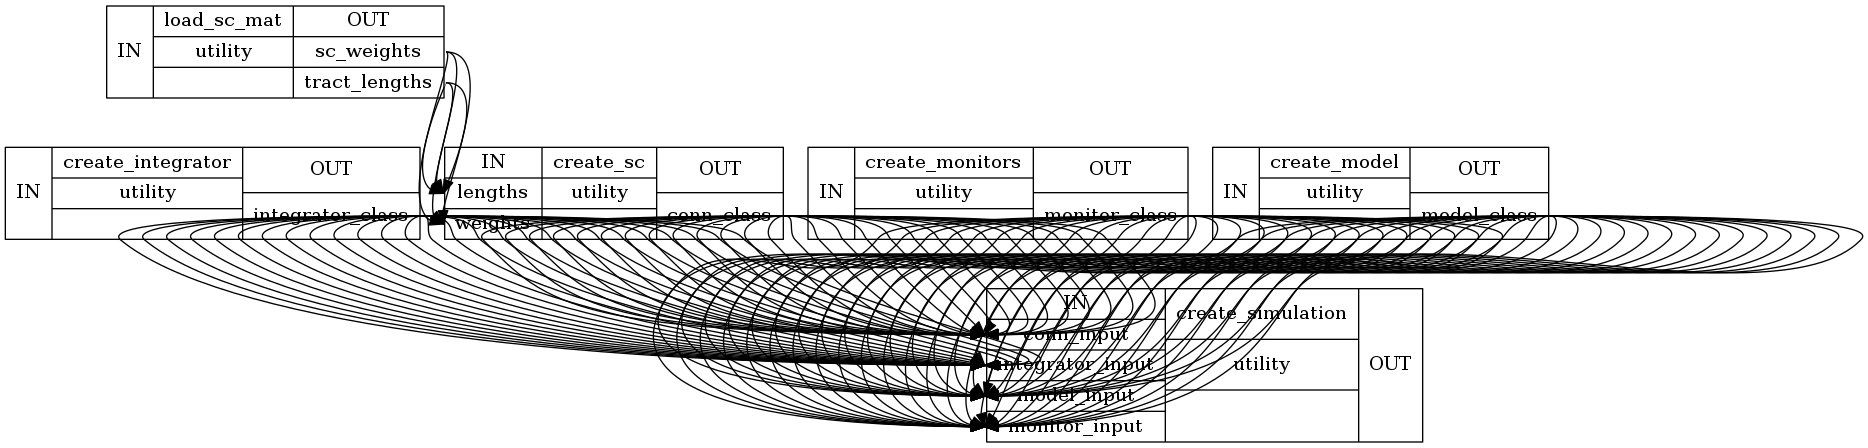

In [5]:
from IPython.display import Image
Image(filename="graph_orig_detailed.png")

In [ ]:
#workflow.run('MultiProc', plugin_args={'n_procs': 10})
# import sys, pickle, numpy
# sys.modules['mtrand'] = numpy.random.mtrand
workflow.run()